In [114]:
import cv2, math, sys, getopt, os
import numpy as np 
import matplotlib.pyplot as plt

In [115]:
def distancia (a,b,n=1): 
    sumatoria=np.sum(np.sqrt(a*b))
    medio= 1/np.sqrt(np.average(a) * np.average(b)*n*n) 
    return math.sqrt((1-(medio*sumatoria)))

In [116]:
def capturarFrames(filename,guardar):
    if guardar:
        path=os.path.dirname(os.path.abspath(filename))
        os.mkdir(path+'/img-'+filename)
    video= cv2.VideoCapture(filename)
    i=0
    success, frame = video.read()
    while success: 
        i+=1
        if guardar:
            nombre = 'img-'+filename+'/'+str(i)+'.jpg'
            cv2.imwrite(nombre, frame) 
        success, frame = video.read()
    return i

In [117]:
def obtenerDistancias(file, comparaciones):
    video= cv2.VideoCapture(file)
    valores = []
    hbins=np.arange(0,179) # rango para canal H
    # Frame 1
    i=0
    success, frame = video.read()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h1,s1,v1 = cv2.split(hsv); 
    # HIST1
    hist1, bins = np.histogram(h1,bins=hbins,density=True)

    while success:
        i+=1
        success, frame2 = video.read()
        if i <= comparaciones:
            hsv2= cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
            h2,s2,v2 = cv2.split(hsv2) 
            # HISTN
            hist2, bins = np.histogram(h2,bins=hbins,density=True)
            valor=distancia(hist1,hist2, len(hbins)-1)
            valores.append(valor)
            hist1=hist2
    return(valores)

In [118]:
def exportData(file, myarray):
    myfile=file+".txt"
    file = open(myfile,"w")
    for el in myarray:
          file.write(str(el)+"\n")
    file.close()

In [122]:
def criterio(dArray,n,precision=1):
    qua= np.power(dArray - np.average(dArray),2)
    parte1=np.sum(dArray)/n
    parte2=np.sqrt(np.sum(qua)/(n-1))
    return 2* (parte1 + parte2)*precision   

In [142]:
def reconstruir(filename, inicio, fin):
    video= cv2.VideoCapture(filename)
    
    fps=video.get(cv2.CAP_PROP_FPS)
    size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    codec =cv2.VideoWriter_fourcc(*'XVID')

    nuevoNombre,extension= filename.split(".")
    nuevoNombre+="-"+str(fin)+'.avi'
    nuevoVideo= cv2.VideoWriter(nuevoNombre,codec,fps,size)   
    i=0
    success, frame = video.read()
    while success:
        if i>=inicio and i<=fin:
            nuevoVideo.write(frame)            
        i+=1
        success, frame = video.read()
        

criterio: 0.07385399045684472


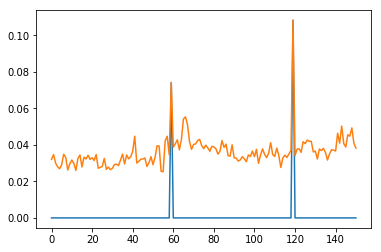

transición:  60 0.07419038254152195
transición:  120 0.10832220838731185


In [143]:
# Info de video
file='360.mp4'
cantFrames=capturarFrames(file,False)
arrayDistancia=obtenerDistancias(file, cantFrames-1)
#exportData(file, arrayDistancia)
valorCriterio=criterio(arrayDistancia,178,0.95)

print("criterio:", valorCriterio)

filtro = (np.where(arrayDistancia>valorCriterio,arrayDistancia,0))

plt.plot(filtro)
plt.plot(arrayDistancia)
plt.show()

#los valores que producen cortes
indice=0
anterior=0
for el in filtro:
    indice+=1
    if el>0:
        print("transición: ",indice,el)
        reconstruir(file, anterior, indice)
        anterior=indice
    if indice==cantFrames-1:
        reconstruir(file, anterior, cantFrames)